In [1]:
import os
os.environ["TURBO_LNM"] = "c:\\Users\\Dataland Control\\painting\\FLUX-LNM-turbo\\turbo_lnm.safetensors"
os.environ["AE"] = "c:\\Users\\Dataland Control\\painting\\FLUX-LNM-turbo\\ae.safetensors"

import re
import time
from glob import iglob
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from fire import Fire
from PIL import ExifTags, Image
from st_keyup import st_keyup
from torchvision import transforms
from transformers import pipeline

from flux.cli import SamplingOptions
from flux.sampling import denoise, get_noise, get_schedule, prepare, unpack
from flux.util import (
    configs,
    embed_watermark,
    load_ae,
    load_clip,
    load_flow_model,
    load_t5,
)

2025-07-22 16:03:54.529 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
c:\TebjanTests\TebjanDemo\Libs\VL.StreamDiffusion\miniconda\envs\painting\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
<frozen importlib._bootstrap_external>:1184: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


In [2]:
def get_models(name: str, device: torch.device, offload: bool, is_schnell: bool):
    t5 = load_t5(device, max_length=256 if is_schnell else 512)
    clip = load_clip(device)
    model = load_flow_model(name, device="cpu" if offload else device)
    ae = load_ae(name, device="cpu" if offload else device)
    nsfw_classifier = pipeline("image-classification", model="Falconsai/nsfw_image_detection", device=device)
    return model, ae, t5, clip, nsfw_classifier

def get_image(path) -> torch.Tensor | None:
    image = Image.open(path).convert("RGB")

    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Lambda(lambda x: 2.0 * x - 1.0),
        ]
    )
    img: torch.Tensor = transform(image)
    return img[None, ...]

In [3]:
name = "turbo-lnm"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
offload = False
is_schnell = name == "flux-schnell"

model, ae, t5, clip, nsfw_classifier = get_models(
    name=name,
    device=device,
    offload=offload,
    is_schnell=is_schnell,
)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Init model
Loading checkpoint
Init AE


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda


In [4]:
@torch.inference_mode()
def do_img2img(
    model, ae, t5, clip, nsfw_classifier,
    image_path: str,
    width: int = 256,
    height: int = 256,
    image2image_strength: float = 0.8,
    num_steps: int = 5,
    guidance: float = 3.5,
    seed: int = 42,
    prompt: str = "a painting of a cat",
    offload: bool = False,
    is_schnell: bool = False,
    output_dir: str = "output",
):
    init_image = get_image(image_path)
    init_image = torch.nn.functional.interpolate(init_image, (width, height))  #TODO: remove this
    
    rng = torch.Generator(device="cpu")
    opts = SamplingOptions(
        prompt=prompt,
        width=width,
        height=height,
        num_steps=num_steps,
        guidance=guidance,
        seed=seed,
    )
    opts.seed = rng.seed()

    print(f"Generating '{opts.prompt}' with seed {opts.seed}")
    t0 = time.perf_counter()

    h, w = init_image.shape[-2:]
    init_image = init_image[..., : 16 * (h // 16), : 16 * (w // 16)]
    opts.height = init_image.shape[-2]
    opts.width = init_image.shape[-1]
    if offload:
        ae.encoder.to(device)
    init_image = ae.encode(init_image.to(device))
    if offload:
        ae = ae.cpu()
        torch.cuda.empty_cache()
        
    # prepare input
    x = get_noise(
        1,
        opts.height,
        opts.width,
        device=device,
        dtype=torch.bfloat16,
        seed=opts.seed,
    )
    # divide pixel space by 16**2 to account for latent space conversion
    timesteps = get_schedule(
        opts.num_steps,
        (x.shape[-1] * x.shape[-2]) // 4,
        shift=(not is_schnell),
    )
    if init_image is not None:
        t_idx = int((1 - image2image_strength) * num_steps)
        t = timesteps[t_idx]
        timesteps = timesteps[t_idx:]
        x = t * x + (1.0 - t) * init_image.to(x.dtype)

    if offload:
        t5, clip = t5.to(device), clip.to(device)
    inp = prepare(t5=t5, clip=clip, img=x, prompt=opts.prompt)

    # offload TEs to CPU, load model to gpu
    if offload:
        t5, clip = t5.cpu(), clip.cpu()
        torch.cuda.empty_cache()
        model = model.to(device)

    # denoise initial noise
    x = denoise(model, **inp, timesteps=timesteps, guidance=opts.guidance)

    # offload model, load autoencoder to gpu
    if offload:
        model.cpu()
        torch.cuda.empty_cache()
        ae.decoder.to(x.device)

    # decode latents to pixel space
    x = unpack(x.float(), opts.height, opts.width)
    with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
        x = ae.decode(x)

    if offload:
        ae.decoder.cpu()
        torch.cuda.empty_cache()

    t1 = time.perf_counter()
    print(f"Done in {t1 - t0:.1f}s.")

    x = x.clamp(-1, 1)
    x = embed_watermark(x.float())
    x = rearrange(x[0], "c h w -> h w c")
    
    img = Image.fromarray((127.5 * (x + 1.0)).cpu().byte().numpy())
    # img.save(f"{output_dir}/demo.png")
    return img

Generating 'abstract red, orange, yellow flames' with seed 67039976915900
Done in 45.5s.


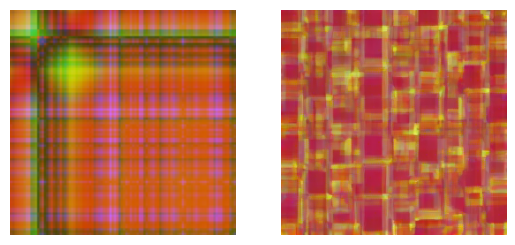

Generating 'abstract red, orange, yellow flames' with seed 67087676279200
Done in 51.8s.


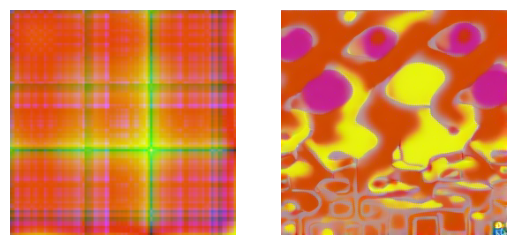

Generating 'abstract red, orange, yellow flames' with seed 67142309753000


KeyboardInterrupt: 

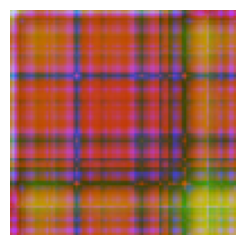

In [9]:
gaf_images = [
    "gaf0-100.png",
    "gaf100-200.png",
    "gaf200-300.png",
    "gaf300-400.png",
]
gaf_images = [f"c:\\Users\\Dataland Control\\painting\\flux\\input\\{img}" for img in gaf_images]

for i, img_path in enumerate(gaf_images):
    
    fig = plt.figure()
    
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    
    generated = do_img2img(
        model=model,
        ae=ae,
        t5=t5,
        clip=clip,
        nsfw_classifier=nsfw_classifier,
        image_path=img_path,
        width=256,
        height=256,
        image2image_strength=0.7,
        num_steps=5,
        guidance=3.5,
        seed=42,
        prompt="abstract red, orange, yellow flames",
        offload=False,
        is_schnell=False,
        output_dir="output",
    )
    plt.subplot(1, 2, 2)
    plt.imshow(generated)
    plt.axis("off")
    plt.show()

Generating 'abstract red, orange, yellow flames' with seed 1258738929500
Done in 49.0s.


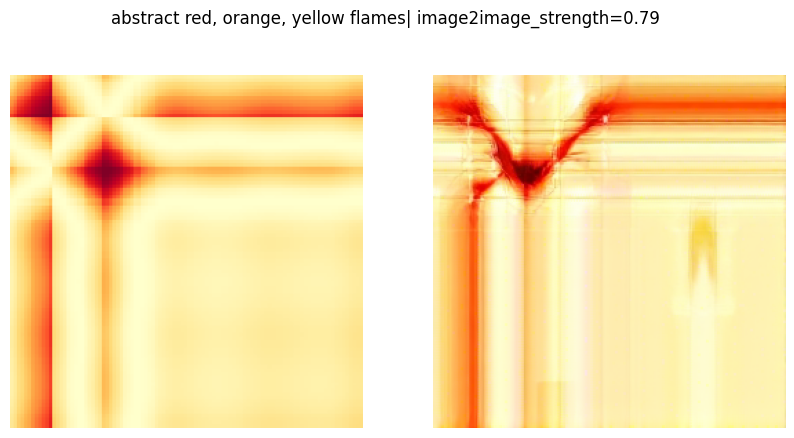

Generating 'abstract red, orange, yellow flames' with seed 1307824915800
Done in 40.1s.


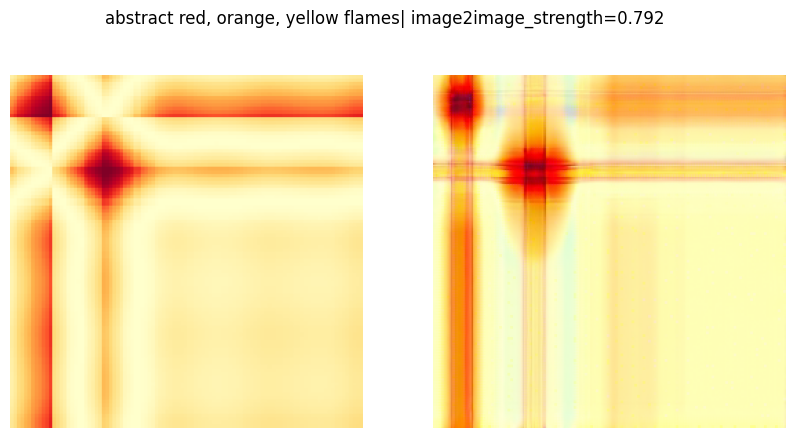

Generating 'abstract red, orange, yellow flames' with seed 1348774992300
Done in 38.2s.


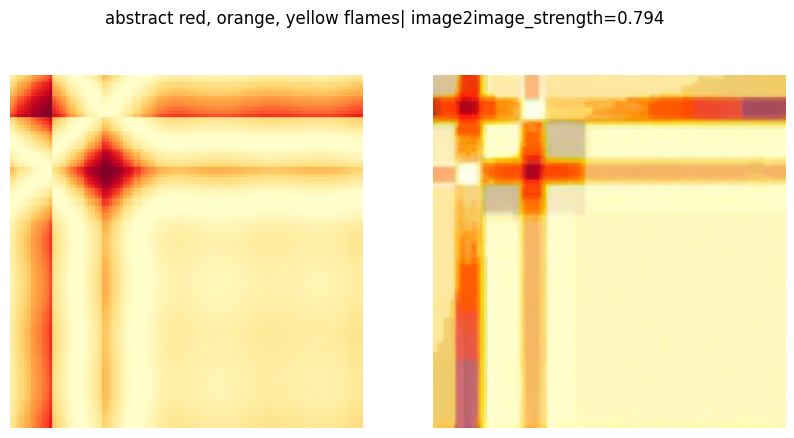

Generating 'abstract red, orange, yellow flames' with seed 1389032067900
Done in 45.3s.


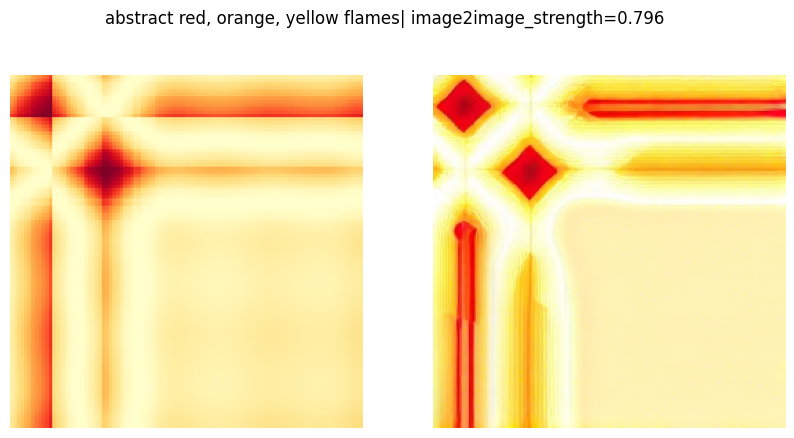

Generating 'abstract red, orange, yellow flames' with seed 1434389679300
Done in 45.5s.


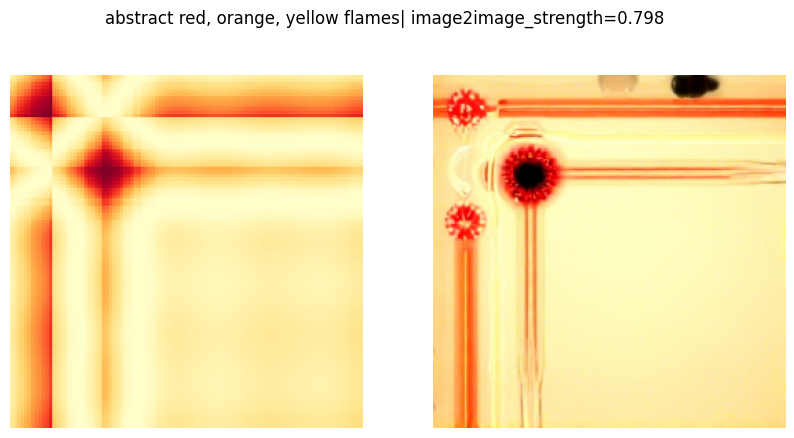

Generating 'abstract red, orange, yellow flames' with seed 1480155882900
Done in 52.5s.


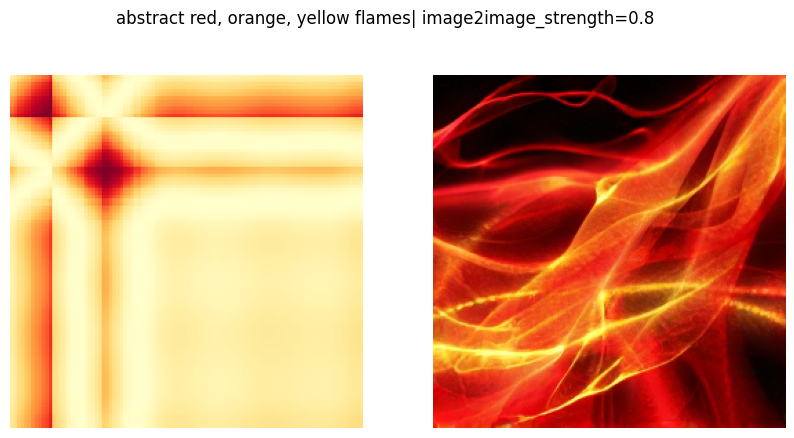

In [8]:
prompt = "abstract red, orange, yellow flames"
img_path = "c:\\Users\\Dataland Control\\painting\\flux\\input\\conduc0-100.png"

for strength in np.linspace(0.79, 0.8, 6):
    fig = plt.figure(figsize=(10, 5))
    
    img = Image.open(img_path).convert("RGB")
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis("off")
    
    generated = do_img2img(
        model=model,
        ae=ae,
        t5=t5,
        clip=clip,
        nsfw_classifier=nsfw_classifier,
        image_path=img_path,
        width=256,
        height=256,
        image2image_strength=strength,
        num_steps=5,
        guidance=3.5,
        seed=42,
        prompt=prompt,
        offload=False,
        is_schnell=False,
        output_dir="output",
    )
    plt.subplot(1, 2, 2)
    plt.imshow(generated)
    plt.axis("off")
    
    plt.suptitle(f"{prompt}| image2image_strength={strength}")
    
    plt.show()

Generating 'abstract red, orange, yellow flames' with seed 1771331644800
Done in 46.4s.


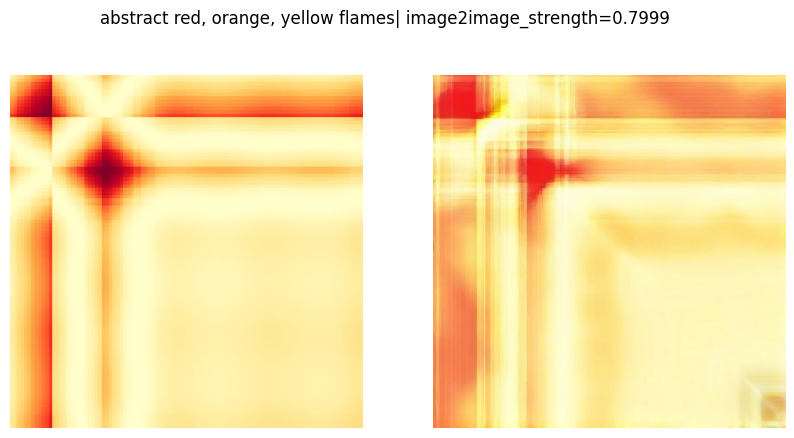

In [11]:
fig = plt.figure(figsize=(10, 5))
    
img = Image.open(img_path).convert("RGB")
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis("off")

generated = do_img2img(
    model=model,
    ae=ae,
    t5=t5,
    clip=clip,
    nsfw_classifier=nsfw_classifier,
    image_path=img_path,
    width=256,
    height=256,
    image2image_strength=0.7999,
    num_steps=5,
    guidance=3.5,
    seed=42,
    prompt=prompt,
    offload=False,
    is_schnell=False,
    output_dir="output",
)
plt.subplot(1, 2, 2)
plt.imshow(generated)
plt.axis("off")

plt.suptitle(f"{prompt}| image2image_strength=0.7999")

plt.show()